# Tests

Purpose:
- Explore for simple correlatd and uncorrelated scenarios under what circumstances the correct posteriors can be reproduced
- Demonstrate how this can be done with **minimum effort** and **small feedback loop**

In [1]:
import numpy as np
import pylab as plt
import swyft
import torch
%load_ext autoreload
%autoreload 2
swyft.set_verbosity(5)

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

DEBUG:root:test


In [2]:
DEVICE = 'cuda:0'

In [65]:
zdim = 10
param_names = ["z"+str(i) for i in range(zdim)]

### Test 1 - No correlations - no zoom

In [106]:
w = [1., 0.00001]
T = sum([(np.eye(zdim,k=-i)+np.eye(zdim,k=i))*w[i] for i in range(1, len(w))]) + np.eye(zdim)*w[0]
sigma = 0.1
F = T.T.dot(T)/sigma**2
errors0 = np.diag(np.linalg.inv(F))**0.5
errors0

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [107]:
def model(params, sigma = sigma):
    z = np.array([params[key] for key in param_names])
    x = T.dot(z)
    return dict(x=x)

In [108]:
def noise(obs, params, sigma = sigma):
    x = obs['x']
    x = x + np.random.randn(*x.shape) * sigma
    return dict(x=x)

In [109]:
par0 = {k: 0.5 for k in param_names}
obs0 = model(par0)
obs0

{'x': array([0.500005, 0.50001 , 0.50001 , 0.50001 , 0.50001 , 0.50001 ,
        0.50001 , 0.50001 , 0.50001 , 0.500005])}

In [110]:
prior = swyft.Prior({k: ["uniform", 0., 1.] for k in param_names})

In [111]:
s = swyft.NestedRatios(model, prior, noise = noise, obs = obs0, device = DEVICE, Ninit = 3000)

In [112]:
s.run(max_rounds=1, train_args = dict(lr_schedule = [1e-3, 1e-4]))

DEBUG:root:Creating new empty MemoryCache.
DEBUG:root:Creating Cache.
DEBUG:root:  params = ['z0', 'z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'z7', 'z8', 'z9']
DEBUG:root:  obs_shapes = {'x': (10,)}
INFO:root:NRE round: R = 1
INFO:root:Number of training samples is N_R = 3000
INFO:root:Additional simulations are required after growing the cache.
Simulate:   1%|          | 21/3000 [00:00<00:14, 201.87it/s]

Creating new cache.
  adding 3000 new samples to simulator cache.


Simulate: 100%|██████████| 3000/3000 [00:14<00:00, 200.02it/s]
INFO:root:Starting neural network training.
DEBUG:root:Initializing swyft.Module with tag `DefaultHead`
DEBUG:root:  args = `()`
DEBUG:root:  kwargs = `{'obs_shapes': {'x': torch.Size([10])}, 'obs_transform': None, 'online_norm': True}`
DEBUG:root:Initializing swyft.Module with tag `DefaultTail`
DEBUG:root:  args = `(10, [('z0',), ('z1',), ('z2',), ('z3',), ('z4',), ('z5',), ('z6',), ('z7',), ('z8',), ('z9',)])`
DEBUG:root:  kwargs = `{'n_tail_features': 2, 'p': 0.0, 'hidden_layers': [256, 256, 256], 'online_norm': True, 'param_transform': None, 'tail_features': False}`
DEBUG:root:Entering trainloop
DEBUG:root:  combinations = None
DEBUG:root:  batch_size = 32
DEBUG:root:  nworkers = 0
DEBUG:root:  max_epochs = 10
DEBUG:root:  early_stopping_patience = 1
DEBUG:root:  lr_schedule = [0.001, 0.0001]
DEBUG:root:  percent_validation = 0
DEBUG:root:lr: 0.001
DEBUG:root:validation loss = 8.71
DEBUG:root:validation loss = 8.727
DEB

In [113]:
samples = s.marginals(obs0, 100000);

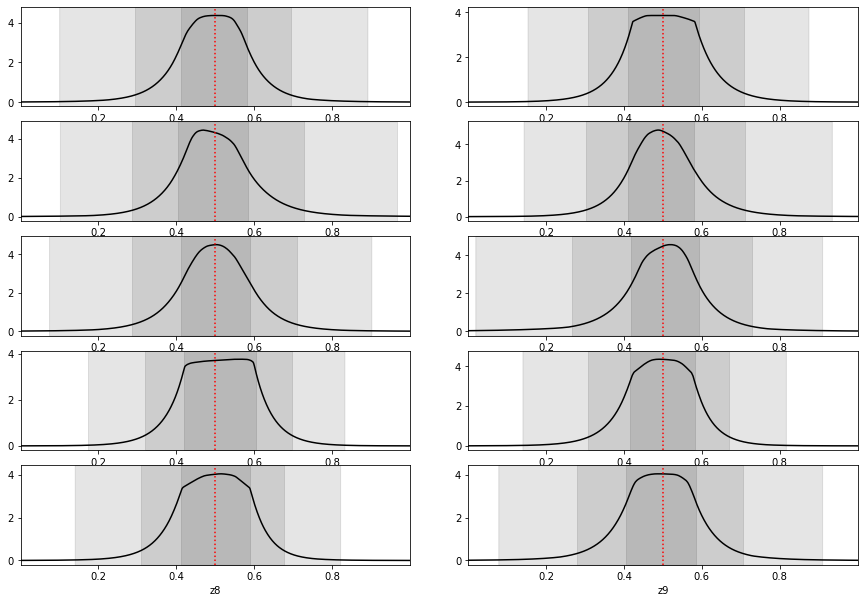

In [114]:
swyft.plot1d(samples, param_names, ncol = 2, truth = par0, grid_interpolate = True)

In [115]:
errors0

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

#### Conclusions:
- 1-sigma and 2-sigma errors are reproduced well
- 3-sigma too wide -- likely needs more training data to get this right 

### Test 2 - Some correlations - no zoom

In [120]:
w = [1., 0.3]
T = sum([(np.eye(zdim,k=-i)+np.eye(zdim,k=i))*w[i] for i in range(1, len(w))]) + np.eye(zdim)*w[0]
sigma = 0.1
F = T.T.dot(T)/sigma**2
errors0 = np.diag(np.linalg.inv(F))**0.5
errors0

array([0.11785113, 0.13608276, 0.13919717, 0.13967524, 0.1397422 ,
       0.1397422 , 0.13967524, 0.13919717, 0.13608276, 0.11785113])

In [121]:
def model(params, sigma = sigma):
    z = np.array([params[key] for key in param_names])
    x = T.dot(z)
    return dict(x=x)

In [122]:
def noise(obs, params, sigma = sigma):
    x = obs['x']
    x = x + np.random.randn(*x.shape) * sigma
    return dict(x=x)

In [123]:
par0 = {k: 0.5 for k in param_names}
obs0 = model(par0)
obs0

{'x': array([0.65, 0.8 , 0.8 , 0.8 , 0.8 , 0.8 , 0.8 , 0.8 , 0.8 , 0.65])}

In [124]:
prior = swyft.Prior({k: ["uniform", 0., 1.] for k in param_names})

In [125]:
s = swyft.NestedRatios(model, prior, noise = noise, obs = obs0, device = DEVICE, Ninit = 3000)

In [126]:
s.run(max_rounds=1, train_args = dict(lr_schedule = [1e-3, 1e-4]))

DEBUG:root:Creating new empty MemoryCache.
DEBUG:root:Creating Cache.
DEBUG:root:  params = ['z0', 'z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'z7', 'z8', 'z9']
DEBUG:root:  obs_shapes = {'x': (10,)}
INFO:root:NRE round: R = 1
INFO:root:Number of training samples is N_R = 3000
INFO:root:Additional simulations are required after growing the cache.
Simulate:   1%|          | 20/3055 [00:00<00:15, 199.37it/s]

Creating new cache.
  adding 3055 new samples to simulator cache.


Simulate: 100%|██████████| 3055/3055 [00:15<00:00, 198.09it/s]
INFO:root:Starting neural network training.
DEBUG:root:Initializing swyft.Module with tag `DefaultHead`
DEBUG:root:  args = `()`
DEBUG:root:  kwargs = `{'obs_shapes': {'x': torch.Size([10])}, 'obs_transform': None, 'online_norm': True}`
DEBUG:root:Initializing swyft.Module with tag `DefaultTail`
DEBUG:root:  args = `(10, [('z0',), ('z1',), ('z2',), ('z3',), ('z4',), ('z5',), ('z6',), ('z7',), ('z8',), ('z9',)])`
DEBUG:root:  kwargs = `{'n_tail_features': 2, 'p': 0.0, 'hidden_layers': [256, 256, 256], 'online_norm': True, 'param_transform': None, 'tail_features': False}`
DEBUG:root:Entering trainloop
DEBUG:root:  combinations = None
DEBUG:root:  batch_size = 32
DEBUG:root:  nworkers = 0
DEBUG:root:  max_epochs = 10
DEBUG:root:  early_stopping_patience = 1
DEBUG:root:  lr_schedule = [0.001, 0.0001]
DEBUG:root:  percent_validation = 0
DEBUG:root:lr: 0.001
DEBUG:root:validation loss = 9.56
DEBUG:root:validation loss = 9.406
DEB

In [127]:
samples = s.marginals(obs0, 100000);

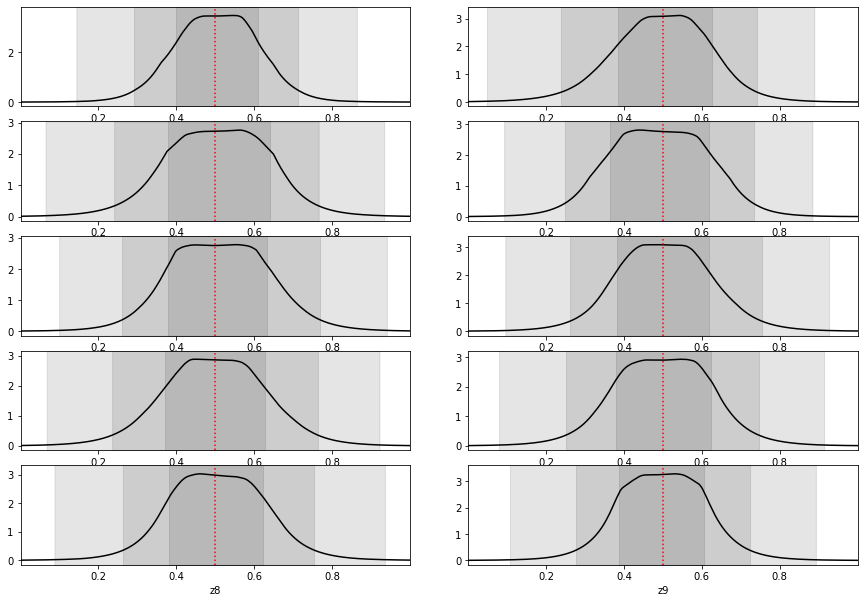

In [128]:
swyft.plot1d(samples, param_names, ncol = 2, truth = par0, grid_interpolate = True)

In [129]:
errors0

array([0.11785113, 0.13608276, 0.13919717, 0.13967524, 0.1397422 ,
       0.1397422 , 0.13967524, 0.13919717, 0.13608276, 0.11785113])

#### Conclusions
- No noticable quality difference w.r.t. test 1

### Test 3 - Some more correlations - no zoom

In [135]:
w = [1., 0.4]
T = sum([(np.eye(zdim,k=-i)+np.eye(zdim,k=i))*w[i] for i in range(1, len(w))]) + np.eye(zdim)*w[0]
sigma = 0.047
F = T.T.dot(T)/sigma**2
errors0 = np.diag(np.linalg.inv(F))**0.5
errors0

array([0.06783816, 0.08973991, 0.09741772, 0.09994674, 0.10068037,
       0.10068037, 0.09994674, 0.09741772, 0.08973991, 0.06783816])

In [136]:
def model(params, sigma = sigma):
    z = np.array([params[key] for key in param_names])
    x = T.dot(z)
    return dict(x=x)

In [137]:
def noise(obs, params, sigma = sigma):
    x = obs['x']
    x = x + np.random.randn(*x.shape) * sigma
    return dict(x=x)

In [138]:
par0 = {k: 0.5 for k in param_names}
obs0 = model(par0)
obs0

{'x': array([0.7, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.7])}

In [139]:
prior = swyft.Prior({k: ["uniform", 0., 1.] for k in param_names})

In [140]:
s = swyft.NestedRatios(model, prior, noise = noise, obs = obs0, device = DEVICE, Ninit = 3000)

In [141]:
s.run(max_rounds=1, train_args = dict(lr_schedule = [1e-3, 1e-4]))

DEBUG:root:Creating new empty MemoryCache.
DEBUG:root:Creating Cache.
DEBUG:root:  params = ['z0', 'z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'z7', 'z8', 'z9']
DEBUG:root:  obs_shapes = {'x': (10,)}
INFO:root:NRE round: R = 1
INFO:root:Number of training samples is N_R = 3000
INFO:root:Additional simulations are required after growing the cache.
Simulate:   1%|          | 21/2918 [00:00<00:14, 203.90it/s]

Creating new cache.
  adding 2918 new samples to simulator cache.


Simulate: 100%|██████████| 2918/2918 [00:14<00:00, 198.46it/s]
INFO:root:Starting neural network training.
DEBUG:root:Initializing swyft.Module with tag `DefaultHead`
DEBUG:root:  args = `()`
DEBUG:root:  kwargs = `{'obs_shapes': {'x': torch.Size([10])}, 'obs_transform': None, 'online_norm': True}`
DEBUG:root:Initializing swyft.Module with tag `DefaultTail`
DEBUG:root:  args = `(10, [('z0',), ('z1',), ('z2',), ('z3',), ('z4',), ('z5',), ('z6',), ('z7',), ('z8',), ('z9',)])`
DEBUG:root:  kwargs = `{'n_tail_features': 2, 'p': 0.0, 'hidden_layers': [256, 256, 256], 'online_norm': True, 'param_transform': None, 'tail_features': False}`
DEBUG:root:Entering trainloop
DEBUG:root:  combinations = None
DEBUG:root:  batch_size = 32
DEBUG:root:  nworkers = 0
DEBUG:root:  max_epochs = 10
DEBUG:root:  early_stopping_patience = 1
DEBUG:root:  lr_schedule = [0.001, 0.0001]
DEBUG:root:  percent_validation = 0
DEBUG:root:lr: 0.001
DEBUG:root:validation loss = 8.867
DEBUG:root:validation loss = 8.223
DE

In [142]:
samples = s.marginals(obs0, 100000);

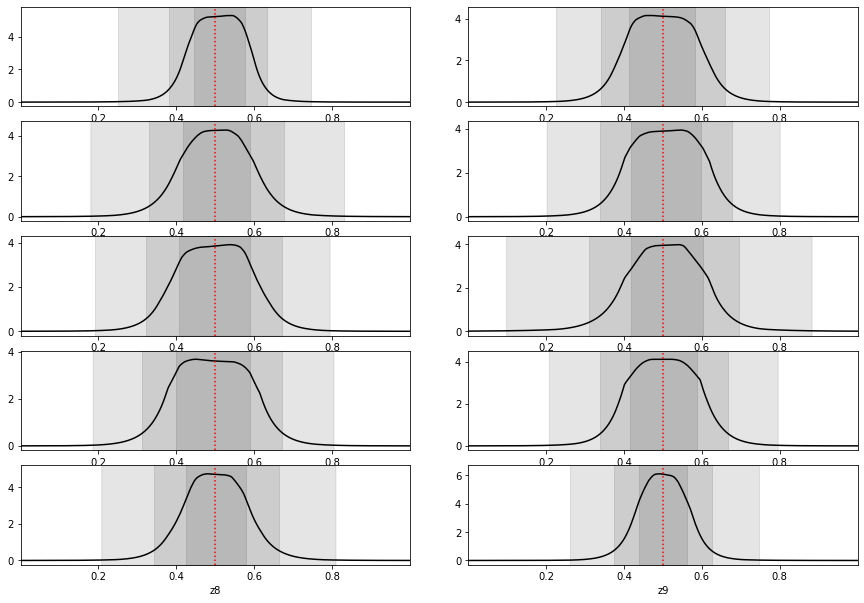

In [143]:
swyft.plot1d(samples, param_names, ncol = 2, truth = par0, grid_interpolate = True)

In [144]:
errors0

array([0.06783816, 0.08973991, 0.09741772, 0.09994674, 0.10068037,
       0.10068037, 0.09994674, 0.09741772, 0.08973991, 0.06783816])

#### Conclusions
- Works still well, with just 3000 samples. Nice.

### Test 4 - Some more correlations + more trainig data - no zoom

In [145]:
w = [1., 0.4]
T = sum([(np.eye(zdim,k=-i)+np.eye(zdim,k=i))*w[i] for i in range(1, len(w))]) + np.eye(zdim)*w[0]
sigma = 0.047
F = T.T.dot(T)/sigma**2
errors0 = np.diag(np.linalg.inv(F))**0.5
errors0

array([0.06783816, 0.08973991, 0.09741772, 0.09994674, 0.10068037,
       0.10068037, 0.09994674, 0.09741772, 0.08973991, 0.06783816])

In [146]:
def model(params, sigma = sigma):
    z = np.array([params[key] for key in param_names])
    x = T.dot(z)
    return dict(x=x)

In [147]:
def noise(obs, params, sigma = sigma):
    x = obs['x']
    x = x + np.random.randn(*x.shape) * sigma
    return dict(x=x)

In [148]:
par0 = {k: 0.5 for k in param_names}
obs0 = model(par0)
obs0

{'x': array([0.7, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.7])}

In [149]:
prior = swyft.Prior({k: ["uniform", 0., 1.] for k in param_names})

In [150]:
s = swyft.NestedRatios(model, prior, noise = noise, obs = obs0, device = DEVICE, Ninit = 15000)

In [151]:
s.run(max_rounds=1, train_args = dict(lr_schedule = [1e-3, 1e-4]))

DEBUG:root:Creating new empty MemoryCache.
DEBUG:root:Creating Cache.
DEBUG:root:  params = ['z0', 'z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'z7', 'z8', 'z9']
DEBUG:root:  obs_shapes = {'x': (10,)}
INFO:root:NRE round: R = 1
INFO:root:Number of training samples is N_R = 15000
INFO:root:Additional simulations are required after growing the cache.
Simulate:   0%|          | 0/14960 [00:00<?, ?it/s]

Creating new cache.
  adding 14960 new samples to simulator cache.


Simulate: 100%|██████████| 14960/14960 [01:06<00:00, 224.46it/s]
INFO:root:Starting neural network training.
DEBUG:root:Initializing swyft.Module with tag `DefaultHead`
DEBUG:root:  args = `()`
DEBUG:root:  kwargs = `{'obs_shapes': {'x': torch.Size([10])}, 'obs_transform': None, 'online_norm': True}`
DEBUG:root:Initializing swyft.Module with tag `DefaultTail`
DEBUG:root:  args = `(10, [('z0',), ('z1',), ('z2',), ('z3',), ('z4',), ('z5',), ('z6',), ('z7',), ('z8',), ('z9',)])`
DEBUG:root:  kwargs = `{'n_tail_features': 2, 'p': 0.0, 'hidden_layers': [256, 256, 256], 'online_norm': True, 'param_transform': None, 'tail_features': False}`
DEBUG:root:Entering trainloop
DEBUG:root:  combinations = None
DEBUG:root:  batch_size = 32
DEBUG:root:  nworkers = 0
DEBUG:root:  max_epochs = 10
DEBUG:root:  early_stopping_patience = 1
DEBUG:root:  lr_schedule = [0.001, 0.0001]
DEBUG:root:  percent_validation = 0
DEBUG:root:lr: 0.001
DEBUG:root:validation loss = 7.85
DEBUG:root:validation loss = 7.738
D

In [152]:
samples = s.marginals(obs0, 100000);

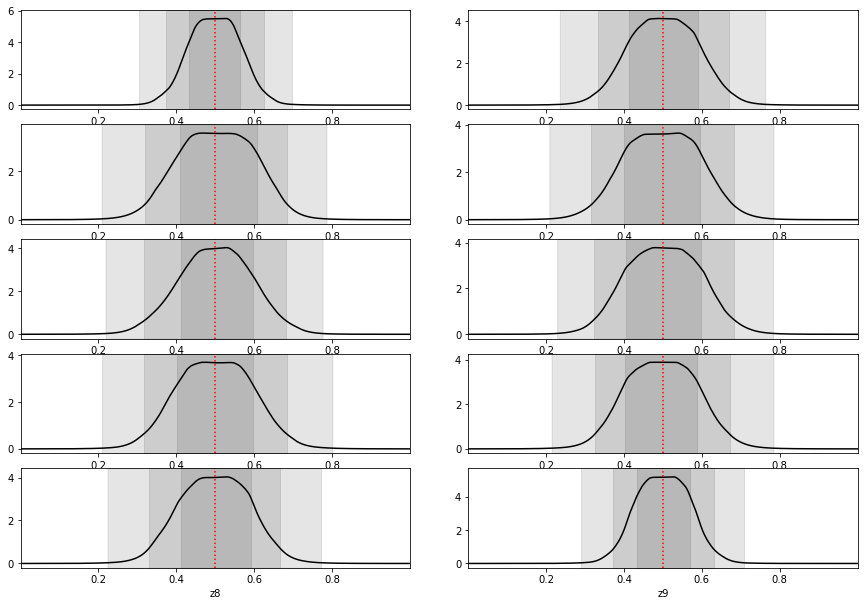

In [153]:
swyft.plot1d(samples, param_names, ncol = 2, truth = par0, grid_interpolate = True)

In [154]:
errors0

array([0.06783816, 0.08973991, 0.09741772, 0.09994674, 0.10068037,
       0.10068037, 0.09994674, 0.09741772, 0.08973991, 0.06783816])

#### Conclusions
- Looks even better, down to 3-sigma tails

### Test 5 - Strong correlations - no zoom

In [158]:
w = [1., 0.5]
T = sum([(np.eye(zdim,k=-i)+np.eye(zdim,k=i))*w[i] for i in range(1, len(w))]) + np.eye(zdim)*w[0]
sigma = 0.01
F = T.T.dot(T)/sigma**2
errors0 = np.diag(np.linalg.inv(F))**0.5
errors0

array([0.0356753 , 0.06353238, 0.08442318, 0.09835002, 0.10531339,
       0.10531339, 0.09835002, 0.08442318, 0.06353238, 0.0356753 ])

In [159]:
def model(params, sigma = sigma):
    z = np.array([params[key] for key in param_names])
    x = T.dot(z)
    return dict(x=x)

In [160]:
def noise(obs, params, sigma = sigma):
    x = obs['x']
    x = x + np.random.randn(*x.shape) * sigma
    return dict(x=x)

In [161]:
par0 = {k: 0.5 for k in param_names}
obs0 = model(par0)
obs0

{'x': array([0.75, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.75])}

In [162]:
prior = swyft.Prior({k: ["uniform", 0., 1.] for k in param_names})

In [163]:
s = swyft.NestedRatios(model, prior, noise = noise, obs = obs0, device = DEVICE, Ninit = 3000)

In [164]:
s.run(max_rounds=1, train_args = dict(lr_schedule = [1e-3, 1e-4]))

DEBUG:root:Creating new empty MemoryCache.
DEBUG:root:Creating Cache.
DEBUG:root:  params = ['z0', 'z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'z7', 'z8', 'z9']
DEBUG:root:  obs_shapes = {'x': (10,)}
INFO:root:NRE round: R = 1
INFO:root:Number of training samples is N_R = 3000
INFO:root:Additional simulations are required after growing the cache.
Simulate:   1%|          | 21/2981 [00:00<00:14, 203.15it/s]

Creating new cache.
  adding 2981 new samples to simulator cache.


Simulate: 100%|██████████| 2981/2981 [00:15<00:00, 197.78it/s]
INFO:root:Starting neural network training.
DEBUG:root:Initializing swyft.Module with tag `DefaultHead`
DEBUG:root:  args = `()`
DEBUG:root:  kwargs = `{'obs_shapes': {'x': torch.Size([10])}, 'obs_transform': None, 'online_norm': True}`
DEBUG:root:Initializing swyft.Module with tag `DefaultTail`
DEBUG:root:  args = `(10, [('z0',), ('z1',), ('z2',), ('z3',), ('z4',), ('z5',), ('z6',), ('z7',), ('z8',), ('z9',)])`
DEBUG:root:  kwargs = `{'n_tail_features': 2, 'p': 0.0, 'hidden_layers': [256, 256, 256], 'online_norm': True, 'param_transform': None, 'tail_features': False}`
DEBUG:root:Entering trainloop
DEBUG:root:  combinations = None
DEBUG:root:  batch_size = 32
DEBUG:root:  nworkers = 0
DEBUG:root:  max_epochs = 10
DEBUG:root:  early_stopping_patience = 1
DEBUG:root:  lr_schedule = [0.001, 0.0001]
DEBUG:root:  percent_validation = 0
DEBUG:root:lr: 0.001
DEBUG:root:validation loss = 9.984
DEBUG:root:validation loss = 9.021
DE

In [165]:
samples = s.marginals(obs0, 100000);

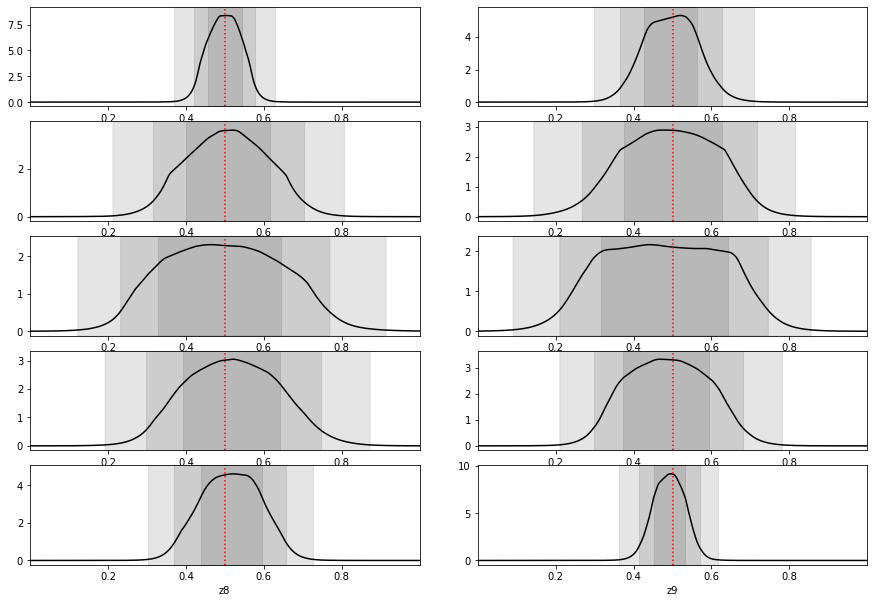

In [166]:
swyft.plot1d(samples, param_names, ncol = 2, truth = par0, grid_interpolate = True)

In [167]:
errors0

array([0.0356753 , 0.06353238, 0.08442318, 0.09835002, 0.10531339,
       0.10531339, 0.09835002, 0.08442318, 0.06353238, 0.0356753 ])

#### Conclusions
- 1-sigma tails are too wide

### Test 6 - Strong correlations & more training data - no zoom

In [168]:
w = [1., 0.5]
T = sum([(np.eye(zdim,k=-i)+np.eye(zdim,k=i))*w[i] for i in range(1, len(w))]) + np.eye(zdim)*w[0]
sigma = 0.01
F = T.T.dot(T)/sigma**2
errors0 = np.diag(np.linalg.inv(F))**0.5
errors0

array([0.0356753 , 0.06353238, 0.08442318, 0.09835002, 0.10531339,
       0.10531339, 0.09835002, 0.08442318, 0.06353238, 0.0356753 ])

In [169]:
def model(params, sigma = sigma):
    z = np.array([params[key] for key in param_names])
    x = T.dot(z)
    return dict(x=x)

In [170]:
def noise(obs, params, sigma = sigma):
    x = obs['x']
    x = x + np.random.randn(*x.shape) * sigma
    return dict(x=x)

In [171]:
par0 = {k: 0.5 for k in param_names}
obs0 = model(par0)
obs0

{'x': array([0.75, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.75])}

In [172]:
prior = swyft.Prior({k: ["uniform", 0., 1.] for k in param_names})

In [173]:
s = swyft.NestedRatios(model, prior, noise = noise, obs = obs0, device = DEVICE, Ninit = 15000)

In [174]:
s.run(max_rounds=1, train_args = dict(lr_schedule = [1e-3, 1e-4]))

DEBUG:root:Creating new empty MemoryCache.
DEBUG:root:Creating Cache.
DEBUG:root:  params = ['z0', 'z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'z7', 'z8', 'z9']
DEBUG:root:  obs_shapes = {'x': (10,)}
INFO:root:NRE round: R = 1
INFO:root:Number of training samples is N_R = 15000
INFO:root:Additional simulations are required after growing the cache.
Simulate:   0%|          | 0/14952 [00:00<?, ?it/s]

Creating new cache.
  adding 14952 new samples to simulator cache.


Simulate: 100%|██████████| 14952/14952 [01:05<00:00, 227.67it/s]
INFO:root:Starting neural network training.
DEBUG:root:Initializing swyft.Module with tag `DefaultHead`
DEBUG:root:  args = `()`
DEBUG:root:  kwargs = `{'obs_shapes': {'x': torch.Size([10])}, 'obs_transform': None, 'online_norm': True}`
DEBUG:root:Initializing swyft.Module with tag `DefaultTail`
DEBUG:root:  args = `(10, [('z0',), ('z1',), ('z2',), ('z3',), ('z4',), ('z5',), ('z6',), ('z7',), ('z8',), ('z9',)])`
DEBUG:root:  kwargs = `{'n_tail_features': 2, 'p': 0.0, 'hidden_layers': [256, 256, 256], 'online_norm': True, 'param_transform': None, 'tail_features': False}`
DEBUG:root:Entering trainloop
DEBUG:root:  combinations = None
DEBUG:root:  batch_size = 32
DEBUG:root:  nworkers = 0
DEBUG:root:  max_epochs = 10
DEBUG:root:  early_stopping_patience = 1
DEBUG:root:  lr_schedule = [0.001, 0.0001]
DEBUG:root:  percent_validation = 0
DEBUG:root:lr: 0.001
DEBUG:root:validation loss = 8.115
DEBUG:root:validation loss = 7.718


In [175]:
samples = s.marginals(obs0, 100000);

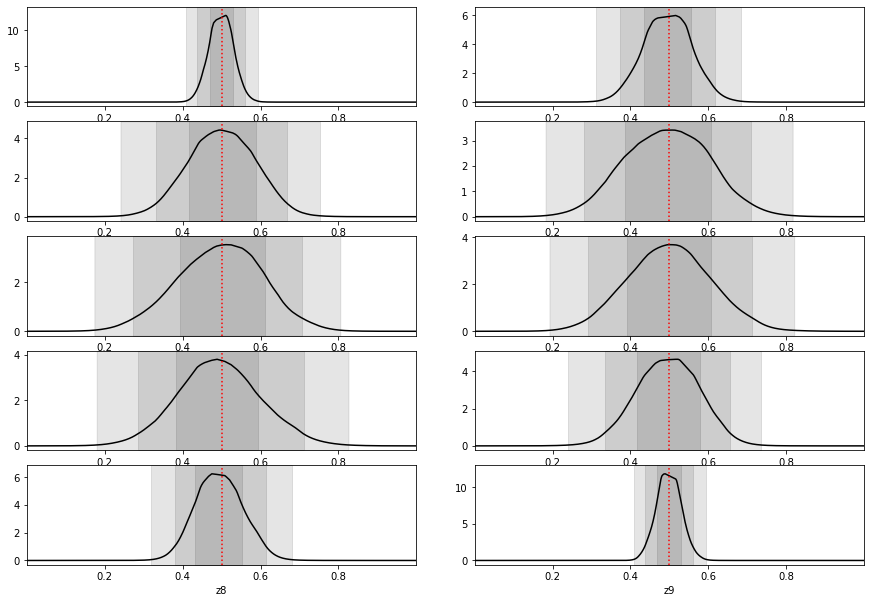

In [176]:
swyft.plot1d(samples, param_names, ncol = 2, truth = par0, grid_interpolate = True)

In [177]:
errors0

array([0.0356753 , 0.06353238, 0.08442318, 0.09835002, 0.10531339,
       0.10531339, 0.09835002, 0.08442318, 0.06353238, 0.0356753 ])

#### Conclusions
- Looks good again!

### Test 7 - Wide strong correlations & more training data - no zoom

In [190]:
w = [1., 0.8, 0.6, 0.4, 0.2]
T = sum([(np.eye(zdim,k=-i)+np.eye(zdim,k=i))*w[i] for i in range(1, len(w))]) + np.eye(zdim)*w[0]
sigma = 0.013
F = T.T.dot(T)/sigma**2
errors0 = np.diag(np.linalg.inv(F))**0.5
errors0

array([0.0718332 , 0.11867322, 0.11867322, 0.11867322, 0.09901524,
       0.09901524, 0.11867322, 0.11867322, 0.11867322, 0.0718332 ])

In [191]:
def model(params, sigma = sigma):
    z = np.array([params[key] for key in param_names])
    x = T.dot(z)
    return dict(x=x)

In [192]:
def noise(obs, params, sigma = sigma):
    x = obs['x']
    x = x + np.random.randn(*x.shape) * sigma
    return dict(x=x)

In [193]:
par0 = {k: 0.5 for k in param_names}
obs0 = model(par0)
obs0

{'x': array([1.5, 1.9, 2.2, 2.4, 2.5, 2.5, 2.4, 2.2, 1.9, 1.5])}

In [194]:
prior = swyft.Prior({k: ["uniform", 0., 1.] for k in param_names})

In [195]:
s = swyft.NestedRatios(model, prior, noise = noise, obs = obs0, device = DEVICE, Ninit = 15000)

In [196]:
s.run(max_rounds=1, train_args = dict(lr_schedule = [1e-3, 1e-4]))

DEBUG:root:Creating new empty MemoryCache.
DEBUG:root:Creating Cache.
DEBUG:root:  params = ['z0', 'z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'z7', 'z8', 'z9']
DEBUG:root:  obs_shapes = {'x': (10,)}
INFO:root:NRE round: R = 1
INFO:root:Number of training samples is N_R = 15000
INFO:root:Additional simulations are required after growing the cache.
Simulate:   0%|          | 0/15181 [00:00<?, ?it/s]

Creating new cache.
  adding 15181 new samples to simulator cache.


Simulate: 100%|██████████| 15181/15181 [01:06<00:00, 227.15it/s]
INFO:root:Starting neural network training.
DEBUG:root:Initializing swyft.Module with tag `DefaultHead`
DEBUG:root:  args = `()`
DEBUG:root:  kwargs = `{'obs_shapes': {'x': torch.Size([10])}, 'obs_transform': None, 'online_norm': True}`
DEBUG:root:Initializing swyft.Module with tag `DefaultTail`
DEBUG:root:  args = `(10, [('z0',), ('z1',), ('z2',), ('z3',), ('z4',), ('z5',), ('z6',), ('z7',), ('z8',), ('z9',)])`
DEBUG:root:  kwargs = `{'n_tail_features': 2, 'p': 0.0, 'hidden_layers': [256, 256, 256], 'online_norm': True, 'param_transform': None, 'tail_features': False}`
DEBUG:root:Entering trainloop
DEBUG:root:  combinations = None
DEBUG:root:  batch_size = 32
DEBUG:root:  nworkers = 0
DEBUG:root:  max_epochs = 10
DEBUG:root:  early_stopping_patience = 1
DEBUG:root:  lr_schedule = [0.001, 0.0001]
DEBUG:root:  percent_validation = 0
DEBUG:root:lr: 0.001
DEBUG:root:validation loss = 10.2
DEBUG:root:validation loss = 9.554
D

In [197]:
samples = s.marginals(obs0, 100000);

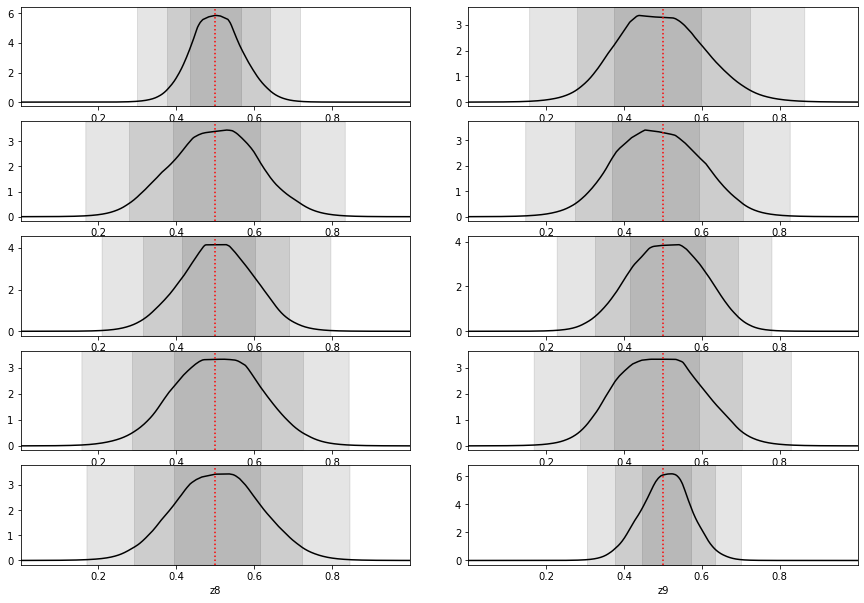

In [198]:
swyft.plot1d(samples, param_names, ncol = 2, truth = par0, grid_interpolate = True)

In [199]:
errors0

array([0.0718332 , 0.11867322, 0.11867322, 0.11867322, 0.09901524,
       0.09901524, 0.11867322, 0.11867322, 0.11867322, 0.0718332 ])

#### Conclusions
- Looks good again!

### Test 8 - Wide strong correlations & more training data - really strong zoom

In [201]:
w = [1., 0.8, 0.6, 0.4, 0.2]
T = sum([(np.eye(zdim,k=-i)+np.eye(zdim,k=i))*w[i] for i in range(1, len(w))]) + np.eye(zdim)*w[0]
sigma = 0.00013
F = T.T.dot(T)/sigma**2
errors0 = np.diag(np.linalg.inv(F))**0.5
errors0

array([0.00071833, 0.00118673, 0.00118673, 0.00118673, 0.00099015,
       0.00099015, 0.00118673, 0.00118673, 0.00118673, 0.00071833])

In [202]:
def model(params, sigma = sigma):
    z = np.array([params[key] for key in param_names])
    x = T.dot(z)
    return dict(x=x)

In [203]:
def noise(obs, params, sigma = sigma):
    x = obs['x']
    x = x + np.random.randn(*x.shape) * sigma
    return dict(x=x)

In [204]:
par0 = {k: 0.5 for k in param_names}
obs0 = model(par0)
obs0

{'x': array([1.5, 1.9, 2.2, 2.4, 2.5, 2.5, 2.4, 2.2, 1.9, 1.5])}

In [205]:
prior = swyft.Prior({k: ["uniform", 0., 1.] for k in param_names})

In [206]:
s = swyft.NestedRatios(model, prior, noise = noise, obs = obs0, device = DEVICE, Ninit = 15000)

In [207]:
s.run(max_rounds=3, train_args = dict(lr_schedule = [1e-3, 1e-4]))

DEBUG:root:Creating new empty MemoryCache.
DEBUG:root:Creating Cache.
DEBUG:root:  params = ['z0', 'z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'z7', 'z8', 'z9']
DEBUG:root:  obs_shapes = {'x': (10,)}
INFO:root:NRE round: R = 1
INFO:root:Number of training samples is N_R = 15000
INFO:root:Additional simulations are required after growing the cache.
Simulate:   0%|          | 0/14957 [00:00<?, ?it/s]

Creating new cache.
  adding 14957 new samples to simulator cache.


Simulate: 100%|██████████| 14957/14957 [01:05<00:00, 227.69it/s]
INFO:root:Starting neural network training.
DEBUG:root:Initializing swyft.Module with tag `DefaultHead`
DEBUG:root:  args = `()`
DEBUG:root:  kwargs = `{'obs_shapes': {'x': torch.Size([10])}, 'obs_transform': None, 'online_norm': True}`
DEBUG:root:Initializing swyft.Module with tag `DefaultTail`
DEBUG:root:  args = `(10, [('z0',), ('z1',), ('z2',), ('z3',), ('z4',), ('z5',), ('z6',), ('z7',), ('z8',), ('z9',)])`
DEBUG:root:  kwargs = `{'n_tail_features': 2, 'p': 0.0, 'hidden_layers': [256, 256, 256], 'online_norm': True, 'param_transform': None, 'tail_features': False}`
DEBUG:root:Entering trainloop
DEBUG:root:  combinations = None
DEBUG:root:  batch_size = 32
DEBUG:root:  nworkers = 0
DEBUG:root:  max_epochs = 10
DEBUG:root:  early_stopping_patience = 1
DEBUG:root:  lr_schedule = [0.001, 0.0001]
DEBUG:root:  percent_validation = 0
DEBUG:root:lr: 0.001
DEBUG:root:validation loss = 9.461
DEBUG:root:validation loss = 8.088


  adding 15096 new samples to simulator cache.


Simulate: 100%|██████████| 15096/15096 [01:03<00:00, 238.39it/s]
INFO:root:Starting neural network training.
DEBUG:root:Initializing swyft.Module with tag `DefaultHead`
DEBUG:root:  args = `()`
DEBUG:root:  kwargs = `{'obs_shapes': {'x': torch.Size([10])}, 'obs_transform': None, 'online_norm': True}`
DEBUG:root:Initializing swyft.Module with tag `DefaultTail`
DEBUG:root:  args = `(10, [('z0',), ('z1',), ('z2',), ('z3',), ('z4',), ('z5',), ('z6',), ('z7',), ('z8',), ('z9',)])`
DEBUG:root:  kwargs = `{'n_tail_features': 2, 'p': 0.0, 'hidden_layers': [256, 256, 256], 'online_norm': True, 'param_transform': None, 'tail_features': False}`
DEBUG:root:Entering trainloop
DEBUG:root:  combinations = None
DEBUG:root:  batch_size = 32
DEBUG:root:  nworkers = 0
DEBUG:root:  max_epochs = 10
DEBUG:root:  early_stopping_patience = 1
DEBUG:root:  lr_schedule = [0.001, 0.0001]
DEBUG:root:  percent_validation = 0
DEBUG:root:lr: 0.001
DEBUG:root:validation loss = 9.899
DEBUG:root:validation loss = 8.262


  adding 15028 new samples to simulator cache.


Simulate: 100%|██████████| 15028/15028 [01:01<00:00, 243.42it/s]
INFO:root:Starting neural network training.
DEBUG:root:Initializing swyft.Module with tag `DefaultHead`
DEBUG:root:  args = `()`
DEBUG:root:  kwargs = `{'obs_shapes': {'x': torch.Size([10])}, 'obs_transform': None, 'online_norm': True}`
DEBUG:root:Initializing swyft.Module with tag `DefaultTail`
DEBUG:root:  args = `(10, [('z0',), ('z1',), ('z2',), ('z3',), ('z4',), ('z5',), ('z6',), ('z7',), ('z8',), ('z9',)])`
DEBUG:root:  kwargs = `{'n_tail_features': 2, 'p': 0.0, 'hidden_layers': [256, 256, 256], 'online_norm': True, 'param_transform': None, 'tail_features': False}`
DEBUG:root:Entering trainloop
DEBUG:root:  combinations = None
DEBUG:root:  batch_size = 32
DEBUG:root:  nworkers = 0
DEBUG:root:  max_epochs = 10
DEBUG:root:  early_stopping_patience = 1
DEBUG:root:  lr_schedule = [0.001, 0.0001]
DEBUG:root:  percent_validation = 0
DEBUG:root:lr: 0.001
DEBUG:root:validation loss = 10.37
DEBUG:root:validation loss = 8.945


In [219]:
samples = s.marginals(obs0, 100000)
for i in range(zdim):
    samples['params']['z%i'%i] = (samples['params']['z%i'%i] - par0['z%i'%i])/errors0[i]

In [227]:
errors0

array([0.00071833, 0.00118673, 0.00118673, 0.00118673, 0.00099015,
       0.00099015, 0.00118673, 0.00118673, 0.00118673, 0.00071833])

In [229]:
len(s.cache)

45081

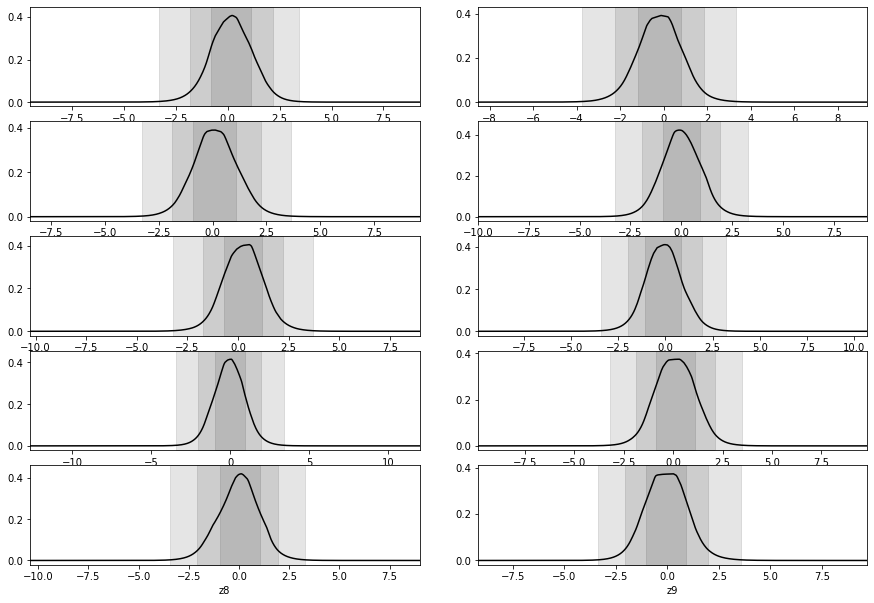

In [226]:
swyft.plot1d(samples, param_names, ncol = 2, grid_interpolate = True)

#### Conclusions
- Looks good again!

In [ ]:
s.run(max_rounds=1, train_args = dict(lr_schedule = [1e-3, 1e-4]))

INFO:root:NRE round: R = 4
INFO:root:Number of training samples is N_R = 18220
INFO:root:Additional simulations are required after growing the cache.


  adding 18116 new samples to simulator cache.


Simulate: 100%|██████████| 18116/18116 [01:15<00:00, 239.03it/s]
INFO:root:Starting neural network training.
DEBUG:root:Initializing swyft.Module with tag `DefaultHead`
DEBUG:root:  args = `()`
DEBUG:root:  kwargs = `{'obs_shapes': {'x': torch.Size([10])}, 'obs_transform': None, 'online_norm': True}`
DEBUG:root:Initializing swyft.Module with tag `DefaultTail`
DEBUG:root:  args = `(10, [('z0',), ('z1',), ('z2',), ('z3',), ('z4',), ('z5',), ('z6',), ('z7',), ('z8',), ('z9',)])`
DEBUG:root:  kwargs = `{'n_tail_features': 2, 'p': 0.0, 'hidden_layers': [256, 256, 256], 'online_norm': True, 'param_transform': None, 'tail_features': False}`
DEBUG:root:Entering trainloop
DEBUG:root:  combinations = None
DEBUG:root:  batch_size = 32
DEBUG:root:  nworkers = 0
DEBUG:root:  max_epochs = 10
DEBUG:root:  early_stopping_patience = 1
DEBUG:root:  lr_schedule = [0.001, 0.0001]
DEBUG:root:  percent_validation = 0
DEBUG:root:lr: 0.001
DEBUG:root:validation loss = 9.823
DEBUG:root:validation loss = 8.705


In [236]:
samples = s.marginals(obs0, 100000)
for i in range(zdim):
    samples['params']['z%i'%i] = (samples['params']['z%i'%i] - par0['z%i'%i])/errors0[i]

In [237]:
errors0

array([0.00071833, 0.00118673, 0.00118673, 0.00118673, 0.00099015,
       0.00099015, 0.00118673, 0.00118673, 0.00118673, 0.00071833])

In [238]:
len(s.cache)

63197

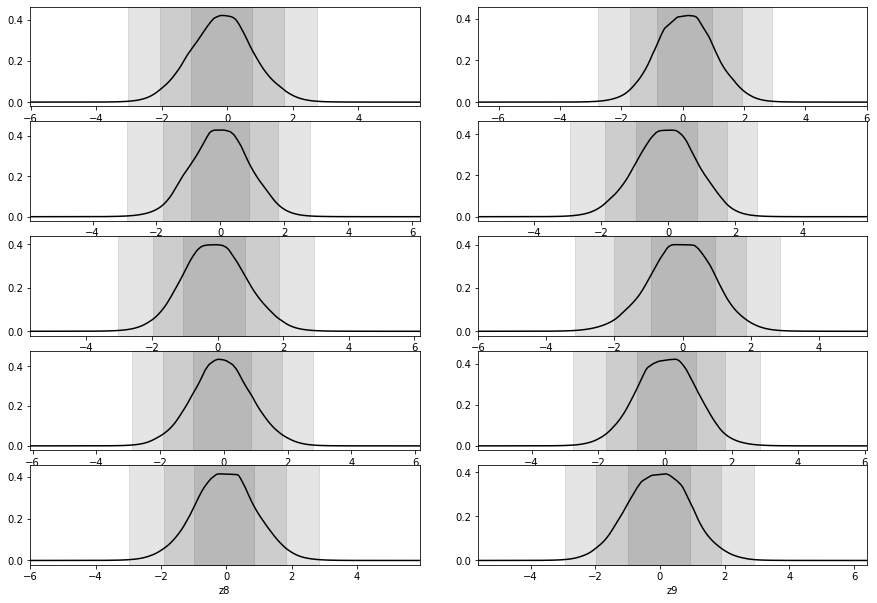

In [239]:
swyft.plot1d(samples, param_names, ncol = 2, grid_interpolate = True)

### Test 9 - Wide strong correlations & more training data - lots of parameters

In [251]:
zdim = 100
param_names = ["z"+str(i) for i in range(zdim)]
w = [1., 0.8, 0.6, 0.4, 0.2]
T = sum([(np.eye(zdim,k=-i)+np.eye(zdim,k=i))*w[i] for i in range(1, len(w))]) + np.eye(zdim)*w[0]
sigma = 0.001
F = T.T.dot(T)/sigma**2
errors0 = np.diag(np.linalg.inv(F))**0.5
errors0

array([0.01812872, 0.03124405, 0.03124405, 0.03124405, 0.03083558,
       0.04544156, 0.05901977, 0.05901977, 0.05901977, 0.05816061,
       0.07087874, 0.08370868, 0.08370868, 0.08370868, 0.08236127,
       0.09339085, 0.10531133, 0.10531133, 0.10531133, 0.10343821,
       0.11284626, 0.12382784, 0.12382784, 0.12382784, 0.12139164,
       0.1292084 , 0.13925824, 0.13925824, 0.13925824, 0.13622173,
       0.14246312, 0.15160255, 0.15160255, 0.15160255, 0.14792866,
       0.1526038 , 0.16086078, 0.16086078, 0.16086078, 0.15651264,
       0.1596269 , 0.16703293, 0.16703293, 0.16703293, 0.16197396,
       0.1635304 , 0.17011901, 0.17011901, 0.17011901, 0.16431303,
       0.16431303, 0.17011901, 0.17011901, 0.17011901, 0.1635304 ,
       0.16197396, 0.16703293, 0.16703293, 0.16703293, 0.1596269 ,
       0.15651264, 0.16086078, 0.16086078, 0.16086078, 0.1526038 ,
       0.14792866, 0.15160255, 0.15160255, 0.15160255, 0.14246312,
       0.13622173, 0.13925824, 0.13925824, 0.13925824, 0.12920

In [252]:
def model(params, sigma = sigma):
    z = np.array([params[key] for key in param_names])
    x = T.dot(z)
    return dict(x=x)

In [253]:
def noise(obs, params, sigma = sigma):
    x = obs['x']
    x = x + np.random.randn(*x.shape) * sigma
    return dict(x=x)

In [254]:
par0 = {k: 0.5 for k in param_names}
obs0 = model(par0)
obs0

{'x': array([1.5, 1.9, 2.2, 2.4, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5,
        2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5,
        2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5,
        2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5,
        2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5,
        2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5,
        2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5,
        2.5, 2.5, 2.5, 2.5, 2.5, 2.4, 2.2, 1.9, 1.5])}

In [255]:
prior = swyft.Prior({k: ["uniform", 0., 1.] for k in param_names})

In [256]:
s = swyft.NestedRatios(model, prior, noise = noise, obs = obs0, device = DEVICE, Ninit = 15000)

In [ ]:
s.run(max_rounds=2, train_args = dict(lr_schedule = [1e-3, 1e-4]))

DEBUG:root:Creating new empty MemoryCache.
DEBUG:root:Creating Cache.
DEBUG:root:  params = ['z0', 'z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'z7', 'z8', 'z9', 'z10', 'z11', 'z12', 'z13', 'z14', 'z15', 'z16', 'z17', 'z18', 'z19', 'z20', 'z21', 'z22', 'z23', 'z24', 'z25', 'z26', 'z27', 'z28', 'z29', 'z30', 'z31', 'z32', 'z33', 'z34', 'z35', 'z36', 'z37', 'z38', 'z39', 'z40', 'z41', 'z42', 'z43', 'z44', 'z45', 'z46', 'z47', 'z48', 'z49', 'z50', 'z51', 'z52', 'z53', 'z54', 'z55', 'z56', 'z57', 'z58', 'z59', 'z60', 'z61', 'z62', 'z63', 'z64', 'z65', 'z66', 'z67', 'z68', 'z69', 'z70', 'z71', 'z72', 'z73', 'z74', 'z75', 'z76', 'z77', 'z78', 'z79', 'z80', 'z81', 'z82', 'z83', 'z84', 'z85', 'z86', 'z87', 'z88', 'z89', 'z90', 'z91', 'z92', 'z93', 'z94', 'z95', 'z96', 'z97', 'z98', 'z99']
DEBUG:root:  obs_shapes = {'x': (100,)}
INFO:root:NRE round: R = 1
INFO:root:Number of training samples is N_R = 15000


Creating new cache.


INFO:root:Additional simulations are required after growing the cache.
Simulate:   0%|          | 3/15098 [00:00<10:15, 24.54it/s]

  adding 15098 new samples to simulator cache.


Simulate: 100%|██████████| 15098/15098 [09:52<00:00, 25.49it/s]
INFO:root:Starting neural network training.
DEBUG:root:Initializing swyft.Module with tag `DefaultHead`
DEBUG:root:  args = `()`
DEBUG:root:  kwargs = `{'obs_shapes': {'x': torch.Size([100])}, 'obs_transform': None, 'online_norm': True}`
DEBUG:root:Initializing swyft.Module with tag `DefaultTail`
DEBUG:root:  args = `(100, [('z0',), ('z1',), ('z2',), ('z3',), ('z4',), ('z5',), ('z6',), ('z7',), ('z8',), ('z9',), ('z10',), ('z11',), ('z12',), ('z13',), ('z14',), ('z15',), ('z16',), ('z17',), ('z18',), ('z19',), ('z20',), ('z21',), ('z22',), ('z23',), ('z24',), ('z25',), ('z26',), ('z27',), ('z28',), ('z29',), ('z30',), ('z31',), ('z32',), ('z33',), ('z34',), ('z35',), ('z36',), ('z37',), ('z38',), ('z39',), ('z40',), ('z41',), ('z42',), ('z43',), ('z44',), ('z45',), ('z46',), ('z47',), ('z48',), ('z49',), ('z50',), ('z51',), ('z52',), ('z53',), ('z54',), ('z55',), ('z56',), ('z57',), ('z58',), ('z59',), ('z60',), ('z61',), 

In [ ]:
samples = s.marginals(obs0, 100000)
for i in range(zdim):
    samples['params']['z%i'%i] = (samples['params']['z%i'%i] - par0['z%i'%i])/errors0[i]

In [ ]:
errors0

In [ ]:
len(s.cache)

In [ ]:
swyft.plot1d(samples, param_names, ncol = 4, grid_interpolate = True)